03_modeling.ipynb — Baseline Models & Evaluation

Goal: train and evaluate models, choose best baseline, document results.
Sections:

1. Load cleaned dataset + pipeline.
2. Train/validation split
    - Temporal split by loan_issue_date.
    - Or quick stratified split if you’re just prototyping.
3. Baseline model: Logistic Regression.
    - Report ROC-AUC, PR-AUC, confusion matrix at a few thresholds.
4. Stronger model: LightGBM.
    - Hyperparameters (basic).
    - SHAP feature importance plot.
5. Calibration (optional but nice).
6. Business metrics
    - Acceptance rate vs default rate at thresholds.
    - Small table/plot showing trade-offs.
7. Save final artifacts (preprocessor + model).

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score



# Load data

In [ ]:
data = pd.read_csv("../02-data/mlcasestudy_to_train.csv")
data.head()

,loan_id,loan_amount,existing_klarna_debt,num_active_loans,days_since_first_loan,days_until_expiration,ratio_failed_3m,ratio_failed_6m,merchant_group,merchant_category,default
0,a55cf3062bd45a83766096fd0c4697d6,5300,21098.0,2,717,953,0.0,0.0,Clothing & Shoes,Adult Shoes & Clothing,0
1,45e3d15cb313d767470722e952e14313,9547,0.0,0,-1,1348,1.0,1.0,"Leisure, Sport & Hobby",Concept Stores & Miscellaneous,1
2,b195c127c7605b7b936b90bcdb5e889c,5948,0.0,0,-1,151,1.0,1.0,Clothing & Shoes,General Shoes & Clothing,0
3,36028b1dbeb4aeef565a79ca9700667a,15871,31742.0,1,0,897,1.0,1.0,Clothing & Shoes,Youthful Shoes & Clothing,0
4,5317f8e22a8f790b6e11a0f12320422d,19510,9064.0,1,501,1036,0.0,0.0,"Leisure, Sport & Hobby",Sports Gear & Outdoor,0


In [67]:
data.columns

Index(['loan_id', 'loan_amount', 'existing_klarna_debt', 'num_active_loans',
       'days_since_first_loan', 'days_until_expiration', 'ratio_failed_3m',
       'ratio_failed_6m', 'merchant_group', 'merchant_category', 'default'],
      dtype='object')

In [68]:
# Prepare the data
X = data.drop(['default', 'loan_id'], axis=1)  # Remove target and ID
y = data['default']


In [69]:
# Handle categorical variables with one-hot encoding
X = pd.get_dummies(X, columns=['merchant_group', 'merchant_category'], drop_first=True)


In [70]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [72]:
# Train the model
#model = LogisticRegression(random_state=42)
model = LogisticRegression(class_weight='balanced', random_state=42) # handles imbalanced data
model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', random_state=42)

In [73]:
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

y_train_pred = model.predict(X_train_scaled)
y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]


### Calculate loss (log loss) for both sets

In [74]:
from sklearn.metrics import log_loss

In [75]:
train_loss = log_loss(y_train, y_train_pred_proba)
test_loss = log_loss(y_test, y_pred_proba)

print(f"Training Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Loss Difference: {test_loss - train_loss:.4f}")


Training Loss: 0.6645
Test Loss: 0.6645
Loss Difference: 0.0001


No significant overfittingm since the loss difference is small.

# Evaluate the model

In [76]:
from sklearn.metrics import roc_curve # not good for imbalanced data
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

In [77]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5876510067114094
ROC AUC: 0.6345734481448091

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     21118
           1       0.08      0.61      0.14      1232

    accuracy                           0.59     22350
   macro avg       0.52      0.60      0.43     22350
weighted avg       0.91      0.59      0.70     22350



In [78]:
ap = average_precision_score(y_test, y_pred)

print(f"Validation PR-AUC: {ap:.3f}")

Validation PR-AUC: 0.070


In [79]:
y_pred.sum() / y_pred.shape[0]

0.4242505592841163

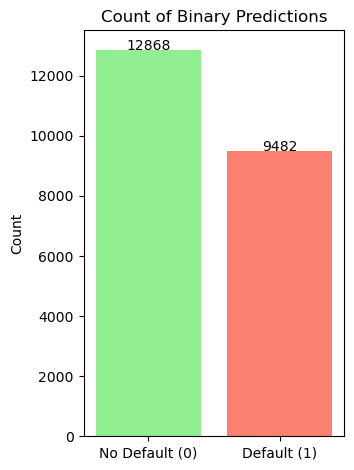


=== PREDICTION COUNTS ===
No Default (0): 12868
Default (1): 9482
Total predictions: 22350
Default rate: 42.4%


In [80]:
# Plot 2: Count of predictions
plt.subplot(1, 2, 2)
pred_counts = pd.Series(y_pred).value_counts()
plt.bar(['No Default (0)', 'Default (1)'], pred_counts.values, color=['lightgreen', 'salmon'])
plt.ylabel('Count')
plt.title('Count of Binary Predictions')
for i, v in enumerate(pred_counts.values):
    plt.text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

# Print counts
print(f"\n=== PREDICTION COUNTS ===")
print(f"No Default (0): {sum(y_pred == 0)}")
print(f"Default (1): {sum(y_pred == 1)}")
print(f"Total predictions: {len(y_pred)}")
print(f"Default rate: {sum(y_pred == 1) / len(y_pred) * 100:.1f}%")

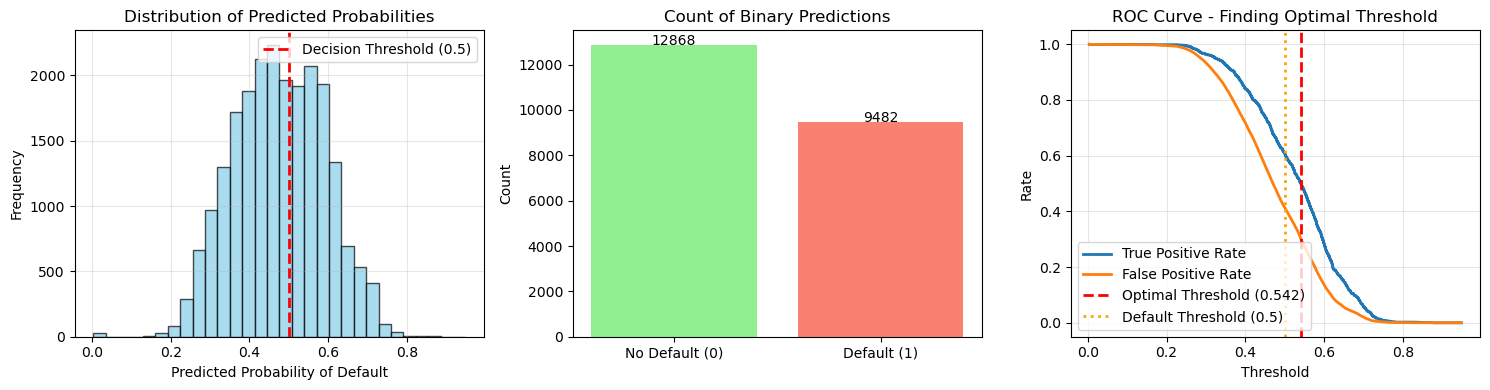

In [81]:
plt.figure(figsize=(15, 4))

# Plot 1: Distribution of probabilities
plt.subplot(1, 3, 1)
plt.hist(y_pred_proba, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Count of predictions
plt.subplot(1, 3, 2)
pred_counts = pd.Series(y_pred).value_counts()
plt.bar(['No Default (0)', 'Default (1)'], pred_counts.values, color=['lightgreen', 'salmon'])
plt.ylabel('Count')
plt.title('Count of Binary Predictions')
for i, v in enumerate(pred_counts.values):
    plt.text(i, v + 5, str(v), ha='center')

# Plot 3: Find optimal threshold using ROC curve
plt.subplot(1, 3, 3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


# Calculate Youden's J statistic to find optimal threshold
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

plt.plot(thresholds, tpr, label='True Positive Rate', linewidth=2)
plt.plot(thresholds, fpr, label='False Positive Rate', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.axvline(x=0.5, color='orange', linestyle=':', linewidth=2, label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('ROC Curve - Finding Optimal Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

PR-AUC: 0.09


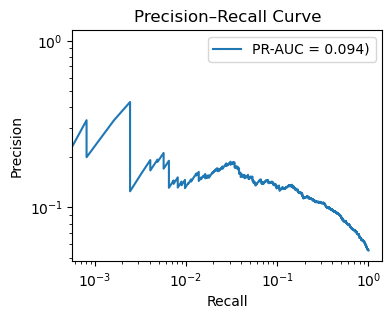

In [82]:
# y_true: true labels (0/1)
# y_proba: predicted probabilities for the positive class (default = 1)
# e.g. y_proba = model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
#auc_score = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.2f}")

# Plot
plt.figure(figsize=(4, 3))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.3f})') #, AUC-score={auc_score:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

- Recall = how many real defaults you catch (avoid approving bad loans)
- Precision = how many loans you decline were actually bad (avoid losing good customers)

So you may prefer high recall if the cost of approving a bad loan is large,
or tune threshold for high precision if declining good loans is more expensive.

# something else

In [83]:
# Test different thresholds
print(f"\n=== THRESHOLD ANALYSIS ===")
print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")

thresholds_to_test = [0.3, 0.4, 0.5, optimal_threshold, 0.6, 0.7]
print(f"\n{'Threshold':<12}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}")
print("-" * 60)

from sklearn.metrics import precision_score, recall_score, f1_score

for threshold in thresholds_to_test:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    print(f"{threshold:<12.3f}{acc:<12.3f}{prec:<12.3f}{rec:<12.3f}{f1:<12.3f}")

# Print counts with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print(f"\n=== PREDICTION COUNTS (Optimal Threshold = {optimal_threshold:.3f}) ===")
print(f"No Default (0): {sum(y_pred_optimal == 0)}")
print(f"Default (1): {sum(y_pred_optimal == 1)}")
print(f"Default rate: {sum(y_pred_optimal == 1) / len(y_pred_optimal) * 100:.1f}%")


=== THRESHOLD ANALYSIS ===
Optimal threshold (Youden's J): 0.542

Threshold   Accuracy    Precision   Recall      F1-Score    
------------------------------------------------------------
0.300       0.117       0.057       0.964       0.107       
0.400       0.313       0.064       0.841       0.119       
0.500       0.588       0.079       0.608       0.140       
0.542       0.692       0.089       0.497       0.151       
0.600       0.831       0.108       0.285       0.156       
0.700       0.928       0.137       0.058       0.082       

=== PREDICTION COUNTS (Optimal Threshold = 0.542) ===
No Default (0): 15479
Default (1): 6871
Default rate: 30.7%


This is a bad model because the probabilities are all very close to 0.5.

?? The PR-AUC is also low at 0.26, indicating poor precision-recall trade-off. The model likely suffers from underfitting or insufficient feature representation.

Key points:
- AUC doesn't change with threshold (it measures performance across all thresholds)
- Optimal threshold maximizes the balance between true positive rate and false positive rate
- Different thresholds optimize for different goals:
    - Lower threshold (0.3): Catches more defaults but more false alarms
    - Higher threshold (0.7): Fewer false alarms but might miss defaults


Remember:
- Precision = “When I predict 1, how often am I correct?”
- Recall = “Of all real 1s, how many did I find?”

# Notes

1. How to deal with imbalanced data?
    - Use different model (XGBoost?)
    - Resampling:
        - Oversample class 1 (e.g. SMOTE, RandomOverSampler)
        - Undersample class 0
        - Or use balanced batch sampling if training with batches.

2. Other things to implement:
- Change threshold for classification 
- hyperparameters
- crossvalidation